# Corn Segmentation

We first import the necessary packages. For this to run you need to install `scikit-image`, `matplotlib`, and `numpy`.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
from plantcv import plantcv as pcv

import skimage
from skimage.measure import regionprops
from skimage.segmentation import felzenszwalb, slic, mark_boundaries

# Make images bigger
plt.rcParams['figure.figsize'] = [15, 12]

We now load an example image. They are located in the `test_imgs` directory. We further normalize the pixels in the image to be in the range [0, 1]. 

In [81]:
file_name = os.path.join("test_imgs", "IMG_0001.JPG")
img = skimage.io.imread(file_name)
img = skimage.util.img_as_float(img[::2, ::2]) # Normalize btwn [0, 1]

f"Image '{file_name}' loaded!"

"Image 'test_imgs/IMG_0001.JPG' loaded!"

The first step to extracting the corn is to apply a segmentation algorithm. This will divide the image into a number of segments. Our goal is to ensure that one of those clusters is the corn.

We attempt to do this using K-Means clustering. This produces the segments by grouping areas of the image that are similar in proximity and color. This is done using the `slic` function. Below is the image separated by the segment boundaries.

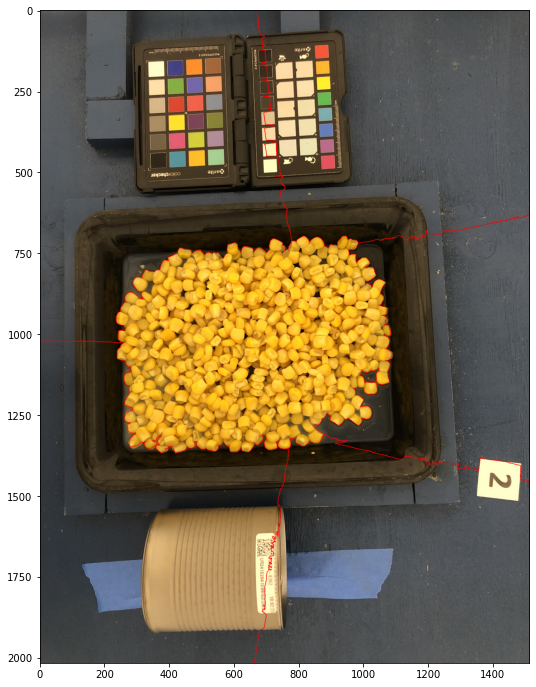

In [3]:
# Apply K-means
img_with_segments = slic(img, n_segments=5, convert2lab=True, compactness=100)

# Show the image with the boundaries
plt.imshow(mark_boundaries(img, img_with_segments, color=(1, 0, 0)))
plt.show()

In order to identify the segment that contains the corn, we rely on an assumption. That assumption is that segment with the corn will be the centermost segment in the image. Assuming the data collection process was consistent, this should be a reasonable assumption.

In order to do this we measure the distance from the center of the image to the center of each segment. This is done in the following steps:

1. Pass the segmented image (output of `slic`) to the `regionprops` function. This returns an object with the properties of each segment. The `centroid` attribute of each segment returned by this function contains the center position of each image.
2. Measure the euclidean distance between the center of each segment and the overall image. This is done using the `dist_from_img_center` function, which takes the segment and the original image as input.
3. We choose the segment with the smallest distance measured from the center of the image.

In [4]:
def dist_from_img_center(segment, img):
    """
    Return euclidean distance from center of image for segement

    Parameters:
    -----------
        segment: regionprops
            Region properties for segment
        img: np.array
            Original image
    
    Returns:
    --------
    float
        distance form segment to center of img
    """
    segment_center = np.array(segment.centroid)
    img_center = np.array([img.shape[0] / 2, img.shape[1] / 2]) 

    return np.linalg.norm(img_center - segment_center, 2)


# Measures distance of each cluster from center of image
segment_dists = [dist_from_img_center(prop, img) for prop in regionprops(img_with_segments)]

# Extract cluster closest to center
center_segment = np.argmin(segment_dists) + 1

f"The centermost segment is {center_segment}!"

'The centermost segment is 4!'

We now want to extract the identified segment of the image that we think identifies the corn. We do this by setting every other segment of the image equal to black.

We can now display the extracted segment and see how we did.

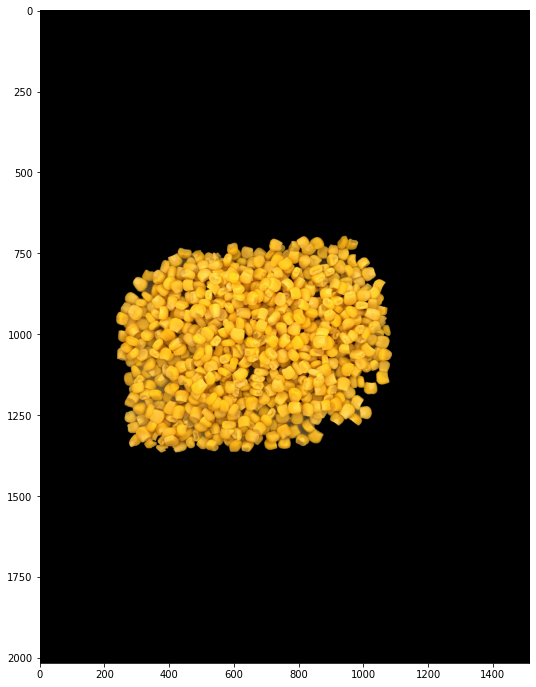

In [89]:
# 'img_with_segments' is just a matrix. we repeat it 3 times so it corresponds to a rgb image
img_with_segments_3d = np.repeat(img_with_segments[:, :, np.newaxis], 3, axis=2)

# Set everything besides center to black
center_mask = np.where(img_with_segments_3d == center_segment, 255, 0)

# Get mask
masked_image = pcv.apply_mask(img, center_mask, 'black')

# Display segmented portion
plt.imshow(masked_image)
plt.show()

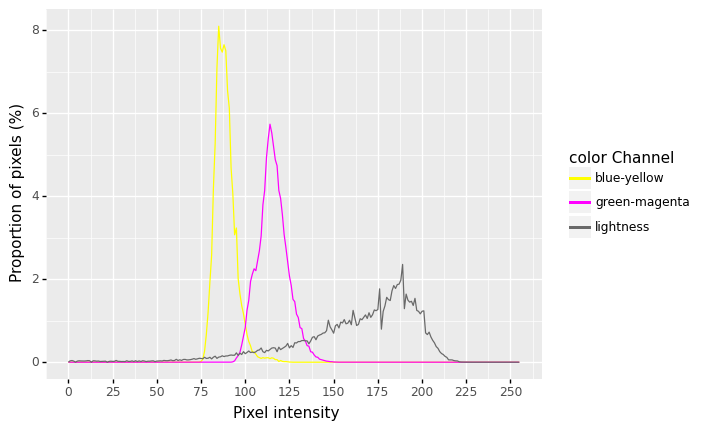

<ggplot: (8729004168873)>

In [95]:
from plantcv import plantcv as pcv

# Convert orignial image back to 0-255
if np.max(img) != 255:
    img = (img * 255).astype(np.uint8)

# Analyze color needs a 2D for some reason
center_mask_2d = center_mask[:, :, 0].astype(np.uint8)

pcv.analyze_color(rgb_img=img, mask=center_mask_2d, hist_plot_type="lab")

In [116]:
img_lab = skimage.color.rgb2lab(img)

masked_img_lab = pcv.apply_mask(img_lab, center_mask, 'black')

# L > 0, take Blue-Yellow channel else 0
blue_yellow = np.where(masked_img_lab[:, :, 0] > 0, masked_img_lab[:, :, 2], 0)

is_not_black = blue_yellow != 0
non_black = blue_yellow[is_not_black]

print("Mean Blue-Yellow:", np.mean(non_black))
print("Median Blue-Yellow:", np.median(non_black))
print("Std Blue-Yellow:", np.std(non_black))
print(f"Range Blue-Yellow: {np.min(non_black)} to {np.max(non_black)}")

# TODO:
# 1. Break down into "N" bins
# 2. Get % of pixels in each bin
# 3. Store metrics for image 

Mean Blue-Yellow: 67.63811502362917
Median Blue-Yellow: 70.30886212153956
Std Blue-Yellow: 10.94580063876622
Range Blue-Yellow: 0.5528311243575112 to 85.25797826823637
